In [1]:

import numpy as np
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.models import Sequential
from keras.api.applications import VGG16
from keras.api.optimizers import Adam
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define new dataset path
train_dir = r"D:\sdp\redd\train"
test_dir = r"D:\sdp\redd\test"

In [2]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load Training & Testing Data
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [3]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
epochs = 10
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs, verbose=2
)

D:\sdp\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


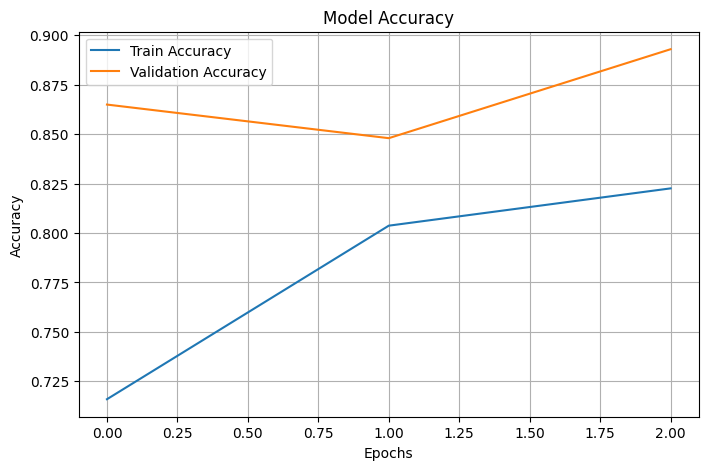

In [23]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)  # Force displayy

plot_accuracy(history)


In [22]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


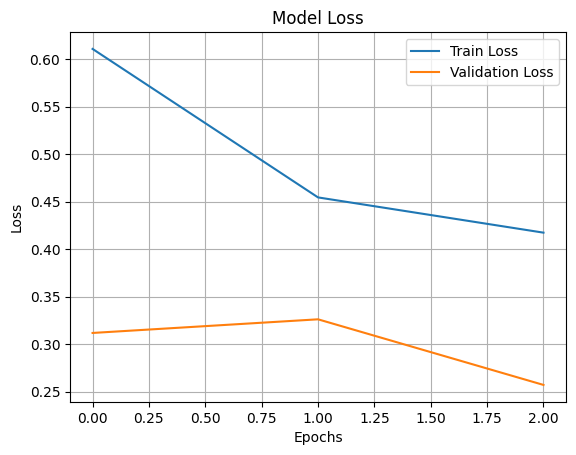

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history)


In [15]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 876ms/step - accuracy: 0.8852 - loss: 0.2669

🔹 Test Accuracy after initial training: 89.30%


In [ ]:
# Fine-Tuning (Unfreeze last 10 layers)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Keep first layers frozen
    layer.trainable = False

# Recompile Model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

# Train Again (Fine-Tuning)
fine_tune_epochs = 3  # Adjust as needed
history_fine = model.fit(
    training_set,
    validation_data=test_set,
    epochs=fine_tune_epochs
)

In [ ]:

# Save Final Model
model.save('sl.keras')

# Load and Predict a Single Image
test_image = image.load_img('D:/sdp/test/img_10.png', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

result = model.predict(test_image)
class_index = np.argmax(result[0])
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

print(f"\n🟢 Prediction: {prediction}")
